In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py
from sunpy.coordinates.sun import carrington_rotation_time
from scipy.stats import gaussian_kde
import datetime
from astropy.time import Time

In [10]:
def calc_solar_cycle_phase(time):
    """
    Function to calculate the solar cycle number, solar cycle phase (between 0-2pi),and solar cycle state (rising=+1,
    falling =-1) for an array of times, provided as julian dates. Dates taken from Wikipedia, could be improved.
    :param time: An array of julian dates
    :return: sc_num     : Solar cycle number
             sc_phase   : Solar cycle phase
             sc_state   : Solar cycle state
             sc_max     : Solar cycle maximum time
             hale_num   : Hale cycle number, assuming polar fields flip 1 year after sunspot maximum.
             hale_phase : Phase of the Hale cycle, assuming polar fields flip 1 year after sunspot maximum.
    """
    # Get start times and max times in julian dates
    start_times_list = ['1744-01-01', '1755-02-01', '1766-06-01', '1775-06-01', '1784-09-01', '1798-04-01',
                        '1810-07-01', '1823-05-01', '1833-11-01', '1843-07-01', '1855-12-01',
                        '1867-03-01', '1878-12-01', '1890-03-01', '1902-01-01', '1913-07-01',
                        '1923-08-01', '1933-09-01', '1944-02-01', '1954-04-01', '1964-10-01',
                        '1976-03-01', '1986-09-01', '1996-08-01', '2008-12-01', '2019-12-01']

    max_times_list = ['1748-01-01', '1761-06-01', '1769-09-01', '1778-05-01', '1788-02-01', '1805-02-01',
                      '1816-05-01', '1829-11-01', '1837-03-01', '1848-02-01', '1860-02-01',
                      '1870-08-01', '1883-12-01', '1894-01-01', '1906-02-01', '1917-08-01',
                      '1928-04-01', '1937-04-01', '1947-05-01', '1958-03-01', '1968-11-01',
                      '1979-12-01', '1989-11-01', '2001-11-01', '2014-04-01', '2024-01-01']

    start_times = pd.to_datetime(start_times_list).to_julian_date()
    max_times = pd.to_datetime(max_times_list).to_julian_date()
    # Calculate cycle lengths
    cycle_length = start_times[1:] - start_times[0:-1]
    # Throw away last cycle start time, so lengths tally.
    start_times = start_times[0:-1]
    max_times = max_times[0:-1]
    # Calculate corresponding solar cycle numbers.
    sc = np.arange(0, len(start_times), dtype='int')
    # Workout sc index of each time.
    idt = np.zeros(time.shape, dtype='int')
    for i, t in enumerate(time):
        idt[i] = np.argwhere(start_times <= t)[-1]

    sc_num = sc[idt]
    sc_phase = 2.0 * np.pi * (time - start_times[idt]) / cycle_length[idt]

    # Get the phase of the maximum for every point.
    sc_phase_max = 2.0 * np.pi * (max_times[idt] - start_times[idt]) / cycle_length[idt]

    # Compute whether in active or quiet phase
    sc_state = -1*np.ones(time.shape)
    # Avg cycle is 11 years and avg active period is 4 years centered on max
    # So assume all active periods are +/- 1.1 rad around max phase
    id_active = (sc_phase >= (sc_phase_max - 1.1)) & (sc_phase <= (sc_phase_max + 1.1))
    sc_state[id_active] = 1

    # Compute whether rising or falling part of cycle
    sc_risefall = np.ones(time.shape)
    sc_risefall[time > max_times[idt]] = -1

    sc_max_phase = 2.0 * np.pi * (max_times[idt] - start_times[idt]) / cycle_length[idt]
    return sc_num, sc_phase, sc_state, sc_risefall

def LoadSSN():

    # Dowload from http://www.sidc.be/silso/DATA/SN_m_tot_V2.0.csv
    filepath = "C:/Users/yq904481/research/repos/CME_transit_climatology/data/SN_m_tot_V2.0.csv"

    col_specification =[(0, 4), (5, 7), (8,16),(17,23),(24,29),(30,35)]
    ssn_df=pd.read_fwf(filepath, colspecs=col_specification,header=None)
    dfdt=np.empty_like(ssn_df[0], dtype=datetime.datetime)
    dfTime=np.empty_like(ssn_df[0], dtype=Time)

    for i in range(0,len(ssn_df)):
        date_string = str(int(ssn_df[0][i])) + '-' + str(int(ssn_df[1][i])) + '-15'

        dfdt[i] = datetime.datetime(int(ssn_df[0][i]),int(ssn_df[1][i]),15)
        dfTime[i] = Time(date_string, format='iso')

    #replace the index with the datetime objects
    ssn_df['datetime']=dfdt
    ssn_df['Time'] = dfTime
    ssn_df["fracyear"]= ssn_df.apply(lambda row: row["Time"].decimalyear, axis=1)

    ssn_df['ssn']=ssn_df[3]

    ssn_df['jd'] = ssn_df.apply(lambda row: row["Time"].jd, axis=1)

    #delete the unwanted columns
    ssn_df.drop(0,axis=1,inplace=True)
    ssn_df.drop(1,axis=1,inplace=True)
    ssn_df.drop(2,axis=1,inplace=True)
    ssn_df.drop(3,axis=1,inplace=True)
    ssn_df.drop(4,axis=1,inplace=True)
    ssn_df.drop(5,axis=1,inplace=True)

    #add the 13-month running smooth
    window = 13*30
    temp = ssn_df.rolling(str(window)+'D', on='datetime').mean()
    ssn_df['smooth'] = np.interp(ssn_df['jd'],temp['jd'],temp['ssn'],
                                              left =np.nan, right =np.nan)
    #drop the incomplete window at the start
    mask = ssn_df['jd'] < ssn_df['jd'].loc[0] + window/2
    ssn_df.loc[mask, 'smooth'] = np.nan

    #add in a solar activity index, which normalises the cycle magnitude
    #approx solar cycle length, in months
    nwindow = int(11*12)
    #find maximum value in a 1-solar cycle bin centred on current time
    ssn_df['rollingmax'] = ssn_df.rolling(nwindow, center = True).max()['smooth']
    #fill the max value at the end of the series
    fillval_end = ssn_df['rollingmax'].dropna().values[-1]
    fillval_start = ssn_df['rollingmax'].dropna().values[0]
    ssn_df['rollingmax'] = ssn_df['rollingmax'].fillna(fillval_end)
    #drop the incomplete window at the start
    mask = ssn_df['jd'] < (ssn_df['jd'].loc[0] + 11*365.25/2)
    ssn_df.loc[mask, 'rollingmax'] = fillval_start
    #create a Solar Activity Index, as SSN normalised to the max smoothed value in
    #1-sc window centred on current tim
    ssn_df['sai'] = ssn_df['smooth']/ssn_df['rollingmax']
    return ssn_df

In [6]:
# load in the CME transit time data
data_path = "C:/Users/yq904481/research/repos/CME_transit_climatology/data/output/transit_data.hdf5"
data = h5py.File(data_path, 'r')

In [7]:
cr_keys = data.keys()
cr_arr = np.arange(1625, 2265, 1)
transit_avg = np.zeros(len(cr_keys))
transit_std = np.zeros(len(cr_keys))

for i, (cr_key, cr_data) in enumerate(data.items()):

    # Convert transits from days to hours
    transits = 24*cr_data['t_transit'][:]
    transit_avg[i] = np.nanmean(transits)
    transit_std[i] = np.nanstd(transits)

C:\Users\yq904481\AppData\Local\Temp\ipykernel_8948\574085580.py:10: RuntimeWarning: Mean of empty slice
  transit_avg[i] = np.nanmean(transits)
C:\Users\yq904481\Anaconda\envs\huxt\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


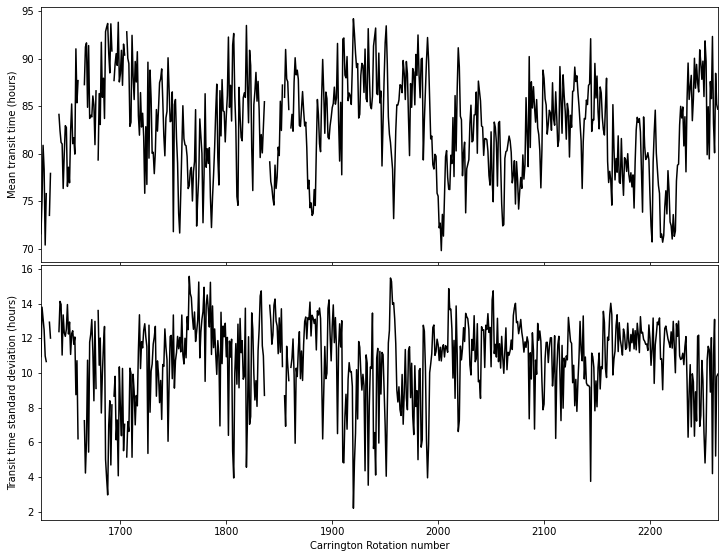

In [8]:
fig, ax = plt.subplots(2, 1, figsize=(10,8))
ax[0].plot(cr_arr, transit_avg, 'k-')
ax[1].plot(cr_arr, transit_std, 'k-')
ax[1].set_xlabel('Carrington Rotation number')
ax[0].set_ylabel('Mean transit time (hours)')
ax[1].set_ylabel('Transit time standard deviation (hours)')
for a in ax:
    a.set_xlim(cr_arr.min(), cr_arr.max())

ax[0].set_xticklabels([])
fig.subplots_adjust(left=0.05, bottom=0.1, right=0.99, top=0.99, hspace=0.01)
fig.savefig('transit_time_time_series.png')

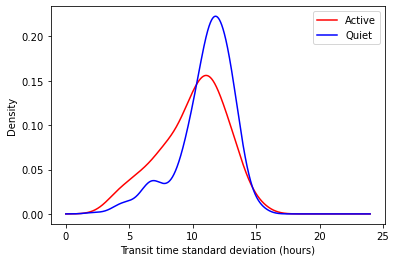

In [11]:
cr_time = carrington_rotation_time(cr_arr+0.5)
cr_sc_num, cr_sc_phase, cr_sc_state, cr_sc_risefall = calc_solar_cycle_phase(cr_time.jd)

transit_active = transit_std[cr_sc_state==1]
transit_quiet = transit_std[cr_sc_state==-1]
# Only keep non-nan values
transit_active = transit_active[np.isfinite(transit_active)]
transit_quiet = transit_quiet[np.isfinite(transit_quiet)]


fig, ax = plt.subplots()
x = np.arange(0, 24, 0.01)
colors = {'Active': 'r', 'Quiet': 'b'}
for label, values in zip(['Active', 'Quiet'], [transit_active, transit_quiet]):
    kernel = gaussian_kde(values)
    density = kernel(x)
    ax.plot(x, density,'-',color=colors[label], label=label)

ax.legend()
ax.set_xlabel('Transit time standard deviation (hours)')
ax.set_ylabel('Density')
fig.savefig('transit_time_phase_distributions.png')

C:\Users\yq904481\Anaconda\envs\huxt\lib\site-packages\erfa\core.py:154: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
C:\Users\yq904481\Anaconda\envs\huxt\lib\site-packages\erfa\core.py:154: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


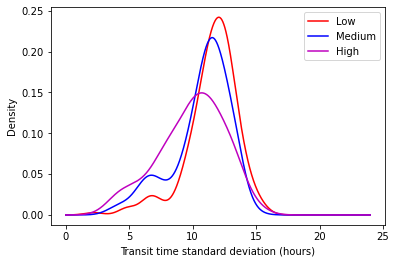

In [16]:
ssn = LoadSSN()

cr_time = carrington_rotation_time(cr_arr+0.5)

# interpolate SAI values onto cr_time julian dates
transits_sai = np.interp(cr_time.jd, ssn['jd'], ssn['sai'])

terciles = np.quantile(transits_sai, [0.333,0.666])
id_low = transits_sai <= terciles[0]
id_mid = (transits_sai > terciles[0]) & (transits_sai <= terciles[1])
id_high = transits_sai > terciles[1]

activity_levels = ['Low', 'Medium', 'High']
colors = ['r', 'b', 'm']
activity_cols = {a:c for a,c in zip(activity_levels, colors)}
x = np.arange(0, 24, 0.01)

fig, ax = plt.subplots()
for label, id_level in zip(activity_levels,[id_low, id_mid, id_high]):
    transit_sub = transit_std[id_level]
    transit_sub = transit_sub[np.isfinite(transit_sub)]
    kernel = gaussian_kde(transit_sub)
    density = kernel(x)
    ax.plot(x, density,'-',color=activity_cols[label], label=label)

ax.legend()
ax.set_xlabel('Transit time standard deviation (hours)')
ax.set_ylabel('Density')
fig.savefig('transit_time_sai_distributions.png')